# Imports

In [1]:
using DataFrames
using CSV
using MLJ
using Plots
using StatsBase

include("../../lib.jl")

ENV["LINES"]=30;

# Datasets

In [2]:
df = CSV.read("data.csv")

,Class,Instance,Nucleotide_Sequence
,String,String,String
1,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCCTTCGAGCCAGTCTG
2,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCCCTCCGTGCCCCCGC
3,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCGGGGGCACGGGGATG
4,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTTGCTCGGTTTTCCCC
5,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCCCGGCCCTTGACCCT
6,EI,CHPIGECA-DONOR-378,CAGACTGGGTGGACAACAAAACCTTCAGCGGTAAGAGAGGGCCAAGCTCAGAGACCACAG
7,EI,CHPIGECA-DONOR-903,CCTTTGAGGACAGCACCAAGAAGTGTGCAGGTACGTTCCCACCTGCCCTGGTGGCCGCCA
8,EI,CHPIGECA-DONOR-1313,CCCTCGTGCGGTCCACGACCAAGACCAGCGGTGAGCCACGGGCAGGCCGGGGTCGTGGGG
9,EI,GCRHBBA1-DONOR-1260,TGGCGACTACGGCGCGGAGGCCCTGGAGAGGTGAGGACCCTCCTGTCCCTGCTCCAGTCC


In [3]:
data = separate_bases(df)

,x1,x2,x3,x4,x5,x6,x7,x8,x9
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,67.0,67.0,65.0,71.0,67.0,84.0,71.0,67.0,65.0
2,65.0,71.0,65.0,67.0,67.0,67.0,71.0,67.0,67.0
3,71.0,65.0,71.0,71.0,84.0,71.0,65.0,65.0,71.0
4,71.0,71.0,71.0,67.0,84.0,71.0,67.0,71.0,84.0
5,71.0,67.0,84.0,67.0,65.0,71.0,67.0,67.0,67.0
6,67.0,65.0,71.0,65.0,67.0,84.0,71.0,71.0,71.0
7,67.0,67.0,84.0,84.0,84.0,71.0,65.0,71.0,71.0
8,67.0,67.0,67.0,84.0,67.0,71.0,84.0,71.0,67.0
9,84.0,71.0,71.0,67.0,71.0,65.0,67.0,84.0,65.0


In [4]:
data = hcat(df,data)

,Class,Instance,Nucleotide_Sequence
,String,String,String
1,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCCTTCGAGCCAGTCTG
2,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCCCTCCGTGCCCCCGC
3,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCGGGGGCACGGGGATG
4,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTTGCTCGGTTTTCCCC
5,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCCCGGCCCTTGACCCT
6,EI,CHPIGECA-DONOR-378,CAGACTGGGTGGACAACAAAACCTTCAGCGGTAAGAGAGGGCCAAGCTCAGAGACCACAG
7,EI,CHPIGECA-DONOR-903,CCTTTGAGGACAGCACCAAGAAGTGTGCAGGTACGTTCCCACCTGCCCTGGTGGCCGCCA
8,EI,CHPIGECA-DONOR-1313,CCCTCGTGCGGTCCACGACCAAGACCAGCGGTGAGCCACGGGCAGGCCGGGGTCGTGGGG
9,EI,GCRHBBA1-DONOR-1260,TGGCGACTACGGCGCGGAGGCCCTGGAGAGGTGAGGACCCTCCTGTCCCTGCTCCAGTCC


In [5]:
# data[:,3:5]

In [6]:
data = data[:, Not(2:3)]

,Class,x1,x2,x3,x4,x5,x6,x7,x8
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,EI,67.0,67.0,65.0,71.0,67.0,84.0,71.0,67.0
2,EI,65.0,71.0,65.0,67.0,67.0,67.0,71.0,67.0
3,EI,71.0,65.0,71.0,71.0,84.0,71.0,65.0,65.0
4,EI,71.0,71.0,71.0,67.0,84.0,71.0,67.0,71.0
5,EI,71.0,67.0,84.0,67.0,65.0,71.0,67.0,67.0
6,EI,67.0,65.0,71.0,65.0,67.0,84.0,71.0,71.0
7,EI,67.0,67.0,84.0,84.0,84.0,71.0,65.0,71.0
8,EI,67.0,67.0,67.0,84.0,67.0,71.0,84.0,71.0
9,EI,84.0,71.0,71.0,67.0,71.0,65.0,67.0,84.0


Look at class labels to see if dataset is imbalanced

In [7]:
label_counts = countmap(data[:Class])

Dict{String,Int64} with 3 entries:
  "IE" => 768
  "EI" => 767
  "N"  => 1655

In [8]:
collect(label_counts[i] / size(data)[1] for i in keys(label_counts))

3-element Array{Float64,1}:
 0.24075235109717869
 0.24043887147335424
 0.5188087774294671

Get data ready for training

In [9]:
coerce!(data, :Class=>Multiclass,
              :Left_Weight=>Continuous,
              :Right_Weight=>Continuous,
              :Left_Distance=>Continuous,
              :Right_Distance=>Continuous)
schema(data)

┌─────────┬─────────────────────────────────┬───────────────┐
│ _.names │ _.types                         │ _.scitypes    │
├─────────┼─────────────────────────────────┼───────────────┤
│ Class   │ CategoricalValue{String,UInt32} │ Multiclass{3} │
│ x1      │ Float64                         │ Continuous    │
│ x2      │ Float64                         │ Continuous    │
│ x3      │ Float64                         │ Continuous    │
│ x4      │ Float64                         │ Continuous    │
│ x5      │ Float64                         │ Continuous    │
│ x6      │ Float64                         │ Continuous    │
│ x7      │ Float64                         │ Continuous    │
│ x8      │ Float64                         │ Continuous    │
│ x9      │ Float64                         │ Continuous    │
│ x10     │ Float64                         │ Continuous    │
│ x11     │ Float64                         │ Continuous    │
│ x12     │ Float64                         │ Continuous    │
│ x13   

In [10]:
y, X = unpack(data, ==(:Class), colname->true)

(CategoricalValue{String,UInt32}["EI", "EI", "EI", "EI", "EI", "EI", "EI", "EI", "EI", "EI"  …  "N", "N", "N", "N", "N", "N", "N", "N", "N", "N"], 3190×60 DataFrame. Omitted printing of 53 columns
│ Row  │ x1      │ x2      │ x3      │ x4      │ x5      │ x6      │ x7      │
│      │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├──────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 1    │ 67.0    │ 67.0    │ 65.0    │ 71.0    │ 67.0    │ 84.0    │ 71.0    │
│ 2    │ 65.0    │ 71.0    │ 65.0    │ 67.0    │ 67.0    │ 67.0    │ 71.0    │
│ 3    │ 71.0    │ 65.0    │ 71.0    │ 71.0    │ 84.0    │ 71.0    │ 65.0    │
│ 4    │ 71.0    │ 71.0    │ 71.0    │ 67.0    │ 84.0    │ 71.0    │ 67.0    │
│ 5    │ 71.0    │ 67.0    │ 84.0    │ 67.0    │ 65.0    │ 71.0    │ 67.0    │
│ 6    │ 67.0    │ 65.0    │ 71.0    │ 65.0    │ 67.0    │ 84.0    │ 71.0    │
│ 7    │ 67.0    │ 67.0    │ 84.0    │ 84.0    │ 84.0    │ 71.0    │ 65.0    │
│ 8    │ 67.0

Partition train and test data accoring to class labels

In [11]:
# data to use when trying to fit a single validation set
train, test = partition(eachindex(y), 0.8, shuffle=true, rng=113) # gives 70:30 split

([898, 1538, 582, 137, 2807, 1511, 1964, 2204, 2307, 2888  …  2265, 1008, 2785, 2454, 1797, 962, 466, 2106, 2519, 2413], [1350, 1105, 2735, 1572, 2149, 113, 1965, 1109, 262, 465  …  625, 1616, 283, 1076, 2074, 743, 3177, 530, 592, 2916])

In [12]:
train_counts = countmap(data[train,:Class])
collect(train_counts[i] / size(train)[1] for i in keys(train_counts))

3-element Array{Float64,1}:
 0.23863636363636365
 0.521551724137931
 0.23981191222570533

In [13]:
test_counts = countmap(data[test,:Class])
collect(test_counts[i] / size(test)[1] for i in keys(test_counts))

3-element Array{Float64,1}:
 0.24921630094043887
 0.5078369905956113
 0.24294670846394983

# Five Learning Algorithms

* Decision trees with some form of pruning
* Neural networks
* Boosting
* Support Vector Machines
* k-nearest neighbors


##### Testing
* Implement the algorithms
* Design two *interesting* classification problems. For the purposes of this assignment, a classification problem is just a set of training examples and a set of test examples.

In [14]:
models(matching(X,y))

42-element Array{NamedTuple{(:name, :package_name, :is_supervised, :docstring, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :is_pure_julia, :is_wrapper, :load_path, :package_license, :package_url, :package_uuid, :prediction_type, :supports_online, :supports_weights, :input_scitype, :target_scitype, :output_scitype),T} where T<:Tuple,1}:
 (name = AdaBoostClassifier, package_name = ScikitLearn, ... )
 (name = AdaBoostStumpClassifier, package_name = DecisionTree, ... )
 (name = BaggingClassifier, package_name = ScikitLearn, ... )
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianLDA, package_name = ScikitLearn, ... )
 (name = BayesianQDA, package_name = ScikitLearn, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = DecisionTreeClassifier, package_name = DecisionTree, ... )
 (name = DeterministicConstantClassifier, package_na

In [15]:
@load SVMClassifier

SVMClassifier(
    C = 1.0,
    kernel = "rbf",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 200,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @306

### Support Vector Machines
* This should be done in such a way that you can swap out kernel functions. I'd like to see at least two.

In [16]:
svm_model = SVMClassifier(kernel="linear")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @782.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:02:06


┌───────────┬───────────────┬─────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                              │
├───────────┼───────────────┼─────────────────────────────────────────┤
│ accuracy  │ 0.808         │ [0.818, 0.803, 0.821, 0.797, 0.8, 0.81] │
└───────────┴───────────────┴─────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [17]:
svm_model = SVMClassifier(kernel="sigmoid")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @395.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:02


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.519         │ [0.509, 0.539, 0.517, 0.521, 0.531, 0.495] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [18]:
svm_model = SVMClassifier(kernel="rbf")
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @615.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:04


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.613         │ [0.632, 0.656, 0.596, 0.602, 0.603, 0.589] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


Poly Degree 2 took a long wall clock time

In [19]:
svm_model = SVMClassifier(kernel="poly", degree=2)
svm_mach = machine(svm_model, X, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @319.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:33


┌───────────┬───────────────┬──────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                               │
├───────────┼───────────────┼──────────────────────────────────────────┤
│ accuracy  │ 0.818         │ [0.823, 0.82, 0.835, 0.81, 0.806, 0.815] │
└───────────┴───────────────┴──────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


Can't use crossentropy because it is a probabilistic concept, and SVM doesn't do probabilities?

##### With Standardization

In [20]:
standardizer = Standardizer()
stand = machine(standardizer, X[train,:])
fit!(stand)
X_stand = MLJ.transform(stand, X);

┌ Info: Training Machine{Standardizer} @003.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


In [21]:
svm_model = SVMClassifier(kernel="linear")
svm_mach = machine(svm_model, X_stand, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @871.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:04


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.799         │ [0.784, 0.771, 0.803, 0.831, 0.793, 0.815] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [22]:
svm_model = SVMClassifier(kernel="sigmoid")
svm_mach = machine(svm_model, X_stand, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @855.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:02


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.77          │ [0.763, 0.759, 0.789, 0.769, 0.795, 0.742] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [23]:
svm_model = SVMClassifier(kernel="rbf")
svm_mach = machine(svm_model, X_stand, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @867.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:02


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.843         │ [0.836, 0.848, 0.814, 0.867, 0.855, 0.838] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [24]:
svm_model = SVMClassifier(kernel="poly", degree=2)
svm_mach = machine(svm_model, X_stand, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @486.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:03


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.729         │ [0.763, 0.737, 0.744, 0.705, 0.708, 0.718] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


### GridSearch / RandomSearch

Use `linear` and `rbf`: 
* `linear` which has high bias
* `rbf` which has high variance

##### First look at `linear`

In [25]:
svm_linear_model = SVMClassifier(kernel="linear", cache_size=1000)
svm_linear_mach = machine(svm_linear_model, X_stand, y)

Machine{SVMClassifier} @421 trained 0 times.
  args: 
    1:	Source @286 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @086 ⏎ `AbstractArray{Multiclass{3},1}`


In [26]:
r1 = range(svm_linear_model, :C, lower=5*10^-1, upper=10^3, scale=:log10)
curve = learning_curve(svm_linear_mach, 
                        range=r1,
                        resampling=CV(), 
                        measure=accuracy, 
                        acceleration=CPUProcesses(),
                        resolution=30)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @958.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 30 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 30 metamodels: 100%[=========================] Time: 2:44:36


(parameter_name = "C",
 parameter_scale = :log10,
 parameter_values = [0.5, 0.6498283059038403, 0.8445536543077102, 1.0976297408473539, 1.4265417500090145, 1.8540144174189153, 2.4095820959852583, 3.1316293027406505, 4.070042729037564, 5.289657943133446  …  94.5240704361715, 122.8488331173453, 159.6612982138162, 207.50486187338385, 269.68506571598283, 350.497978763566, 455.52701552529663, 592.0286975844718, 769.4340111955487, 1000.0],
 measurements = [0.6912608734642633, 0.69408278228528, 0.6931417526868017, 0.6984687471975608, 0.6978427707687298, 0.7003496264200991, 0.703797511669947, 0.7019172224346176, 0.7009785527849757, 0.7009779627977665  …  0.702233455578683, 0.7031738951899523, 0.7034865884107632, 0.7038004616059923, 0.7038004616059923, 0.7034865884107632, 0.7031733052027431, 0.702859432007514, 0.7034865884107632, 0.7037998716187833],)

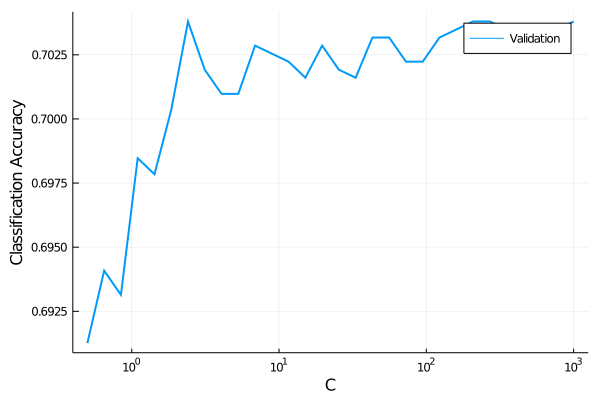

In [27]:
plot(curve.parameter_values,
     curve.measurements,
     xscale=curve.parameter_scale,
     xlab=curve.parameter_name,
     ylab="Classification Accuracy",
     label="Validation", lw=2)

In [28]:
a = round(maximum(curve.measurements), digits=5)

0.7038

In [29]:
best_C = curve.parameter_values[argmax(curve.measurements)]

207.50486187338385

##### Second look at `rbf`

In [30]:
r1 = range(Float64, :C, lower=5*10^1, upper=5*10^4, scale=:log10)
r2 = range(Float64, :gamma, lower=10^-4, upper=10^0, scale=:log10)

MLJBase.NumericRange(Float64, :gamma, ... )

In [31]:
svm_rbf_model = SVMClassifier(kernel="rbf", cache_size=1000)
self_tuning_svm_model = TunedModel(model=svm_rbf_model,
                                    tuning=Grid(goal=100),
                                    resampling=CV(), 
                                    measure=accuracy,
                                    acceleration=CPUThreads(),
                                    range=[r1,r2])

DeterministicTunedModel(
    model = SVMClassifier(
            C = 1.0,
            kernel = "rbf",
            degree = 3,
            gamma = "auto",
            coef0 = 0.0,
            shrinking = true,
            tol = 0.001,
            cache_size = 1000,
            max_iter = -1,
            decision_function_shape = "ovr",
            random_state = nothing),
    tuning = Grid(
            goal = 100,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = accuracy(),
    weights = nothing,
    operation = MLJModelInterface.predict,
    range = MLJBase.NumericRange{Float64,MLJBase.Bounded,Symbol}[NumericRange{Float64,…} @649, NumericRange{Float64,…} @456],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = CPUThreads{Int64}(1),
    acceleration_resampling = CPU1{Nothing}(nothing),
 

In [32]:
self_tuning_svm_mach = machine(self_tuning_svm_model, X_stand, y)

Machine{DeterministicTunedModel{Grid,…}} @540 trained 0 times.
  args: 
    1:	Source @561 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @301 ⏎ `AbstractArray{Multiclass{3},1}`


In [33]:
z = fit!(self_tuning_svm_mach, rows=train)

┌ Info: Training Machine{DeterministicTunedModel{Grid,…}} @540.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning /home/andrew/.julia/packages/MLJTuning/Bbgvk/src/tuned_models.jl:494
Evaluating over 100 metamodels: 100%[=========================] Time: 0:04:40


Machine{DeterministicTunedModel{Grid,…}} @540 trained 1 time.
  args: 
    1:	Source @561 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @301 ⏎ `AbstractArray{Multiclass{3},1}`


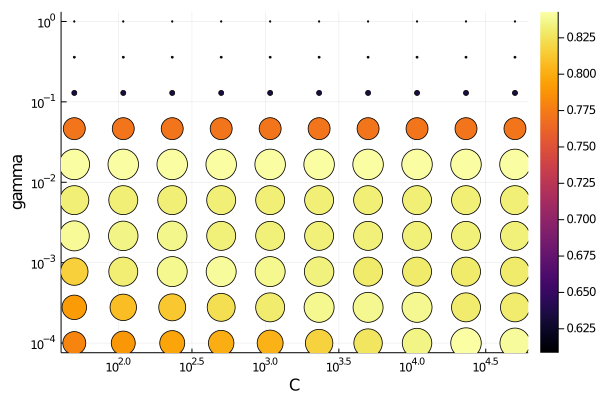

In [34]:
plot(self_tuning_svm_mach)

In [35]:
best_rbf = fitted_params(self_tuning_svm_mach)
best_rbf

(best_model = SVMClassifier @909,
 best_fitted_params = (support = Int32[26, 29, 37, 41, 57, 64, 66, 70, 74, 77  …  2513, 2519, 2525, 2532, 2536, 2539, 2540, 2542, 2549, 2550],
                       support_vectors = [-0.9167845601850195 -0.6290712031467441 … -0.9024500990490927 1.7390794520478359; -0.6372416726060517 -0.07772245739917198 … -0.9024500990490927 1.7390794520478359; … ; -0.6372416726060517 -0.9047455760205302 … -0.07831245268184164 -0.09357730105358646; 1.7388728718151745 -0.07772245739917198 … -0.07831245268184164 -0.939418879408089],
                       n_support = Int32[319, 380, 463],
                       dual_coef = [0.0 0.0 … -0.0 -0.0; 14439.136567507458 2905.934129227948 … -14082.417572581855 -9549.677420880415],
                       coef = nothing,
                       intercept = [-259.19813647257877, -396.4538144958955, -188.2609118561251],
                       fit_status = 0,
                       classes = UInt32[0x00000001, 0x00000002, 0x0000000

In [36]:
best_rbf.best_model

SVMClassifier(
    C = 23207.944168063907,
    kernel = "rbf",
    degree = 3,
    gamma = 0.0001,
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @909

In [37]:
best_loss = round(z.report.best_result.measurement[1],digits=5)

0.84288

In [38]:
# fn = "Figures/LearningCurve_DT_merge_purity_thresh:$(best_mpt)_loss:$(best_loss)"
# png(replace(fn,'.' => ','))

##### More fitting

In [39]:
best_linear_model = SVMClassifier(kernel="linear", C = best_C)
svm_mach = machine(best_linear_model, X_stand, y)
lf = fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @185.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:09:40


┌───────────┬───────────────┬────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                 │
├───────────┼───────────────┼────────────────────────────────────────────┤
│ accuracy  │ 0.81          │ [0.825, 0.808, 0.833, 0.801, 0.774, 0.817] │
└───────────┴───────────────┴────────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


In [40]:
best_rbf_model = SVMClassifier(kernel="rbf", C=best_rbf.best_model.C, gamma=best_rbf.best_model.gamma)
svm_mach = machine(best_rbf_model, X_stand, y)
fit!(svm_mach, rows=train, verbosity=2)
svm_acc = evaluate!(svm_mach, resampling=CV(shuffle=true), measure=[accuracy], 
                        verbosity=1)

┌ Info: Training Machine{SVMClassifier} @862.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319
Evaluating over 6 folds: 100%[=========================] Time: 0:00:11


┌───────────┬───────────────┬───────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                │
├───────────┼───────────────┼───────────────────────────────────────────┤
│ accuracy  │ 0.85          │ [0.88, 0.827, 0.855, 0.827, 0.851, 0.859] │
└───────────┴───────────────┴───────────────────────────────────────────┘
_.per_observation = [missing]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


### Learning Curves

In [41]:
data_schedule, training_losses, valid_losses = learn_curve(best_linear_model, X_stand[train,:], y[train], step=50)

(d, train_metric, valid_metric) = (10, 1.0, 0.5686274509803921)
(d, train_metric, valid_metric) = (60, 1.0, 0.5901960784313726)
(d, train_metric, valid_metric) = (110, 1.0, 0.6529411764705882)
(d, train_metric, valid_metric) = (160, 1.0, 0.7039215686274509)
(d, train_metric, valid_metric) = (210, 1.0, 0.7078431372549019)
(d, train_metric, valid_metric) = (260, 1.0, 0.7078431372549019)
(d, train_metric, valid_metric) = (310, 0.9774193548387097, 0.6784313725490196)
(d, train_metric, valid_metric) = (360, 0.9638888888888889, 0.692156862745098)
(d, train_metric, valid_metric) = (410, 0.9585365853658536, 0.6941176470588235)
(d, train_metric, valid_metric) = (460, 0.9565217391304348, 0.711764705882353)
(d, train_metric, valid_metric) = (510, 0.9352941176470588, 0.7274509803921569)
(d, train_metric, valid_metric) = (560, 0.9232142857142858, 0.7235294117647059)
(d, train_metric, valid_metric) = (610, 0.9016393442622951, 0.7392156862745098)
(d, train_metric, valid_metric) = (660, 0.906060606060

(10:50:2010, Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9774193548387097, 0.9638888888888889, 0.9585365853658536, 0.9565217391304348  …  0.8467948717948718, 0.8490683229813665, 0.8560240963855421, 0.8526315789473684, 0.8522727272727273, 0.8475138121546961, 0.8473118279569892, 0.8492146596858638, 0.8474489795918367, 0.8487562189054727], Any[0.5686274509803921, 0.5901960784313726, 0.6529411764705882, 0.7039215686274509, 0.7078431372549019, 0.7078431372549019, 0.6784313725490196, 0.692156862745098, 0.6941176470588235, 0.711764705882353  …  0.8058823529411765, 0.8, 0.7862745098039216, 0.792156862745098, 0.7941176470588236, 0.792156862745098, 0.7980392156862746, 0.7901960784313725, 0.7941176470588236, 0.792156862745098])

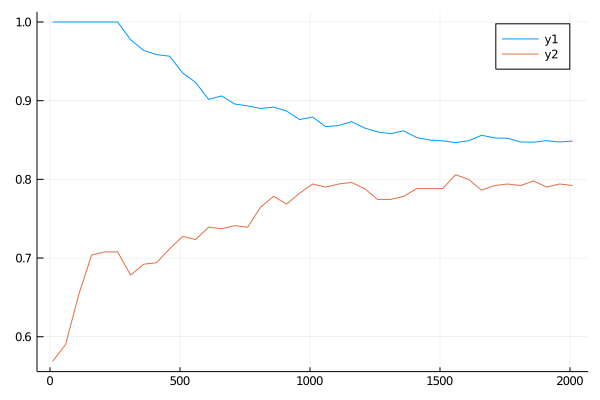

In [42]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

In [43]:
data_schedule, training_losses, valid_losses = learn_curve(best_rbf_model, X_stand[train,:], y[train], step=50)

(d, train_metric, valid_metric) = (10, 1.0, 0.5686274509803921)
(d, train_metric, valid_metric) = (60, 1.0, 0.5901960784313726)
(d, train_metric, valid_metric) = (110, 1.0, 0.6509803921568628)
(d, train_metric, valid_metric) = (160, 1.0, 0.7039215686274509)
(d, train_metric, valid_metric) = (210, 1.0, 0.7039215686274509)
(d, train_metric, valid_metric) = (260, 1.0, 0.7)
(d, train_metric, valid_metric) = (310, 0.9967741935483871, 0.7058823529411764)
(d, train_metric, valid_metric) = (360, 0.9972222222222222, 0.7)
(d, train_metric, valid_metric) = (410, 0.9951219512195122, 0.7058823529411764)
(d, train_metric, valid_metric) = (460, 0.9934782608695653, 0.7352941176470589)
(d, train_metric, valid_metric) = (510, 0.996078431372549, 0.7509803921568627)
(d, train_metric, valid_metric) = (560, 0.9928571428571429, 0.7490196078431373)
(d, train_metric, valid_metric) = (610, 0.9901639344262295, 0.7607843137254902)
(d, train_metric, valid_metric) = (660, 0.990909090909091, 0.7725490196078432)
(d, 

(10:50:2010, Any[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9967741935483871, 0.9972222222222222, 0.9951219512195122, 0.9934782608695653  …  0.9865384615384616, 0.9850931677018634, 0.9855421686746988, 0.9842105263157894, 0.9840909090909091, 0.9861878453038674, 0.986021505376344, 0.9853403141361257, 0.986734693877551, 0.9850746268656716], Any[0.5686274509803921, 0.5901960784313726, 0.6509803921568628, 0.7039215686274509, 0.7039215686274509, 0.7, 0.7058823529411764, 0.7, 0.7058823529411764, 0.7352941176470589  …  0.8490196078431372, 0.8529411764705882, 0.8549019607843137, 0.8529411764705882, 0.8568627450980393, 0.8627450980392157, 0.8549019607843137, 0.8647058823529412, 0.8568627450980393, 0.8549019607843137])

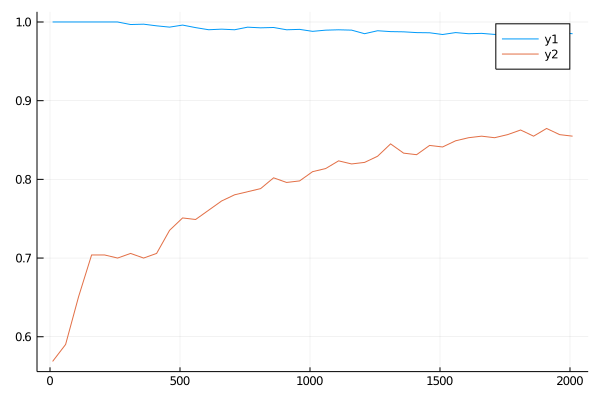

In [44]:
plot(data_schedule, training_losses)
plot!(data_schedule, valid_losses)

# Final Results

Linear SVM

In [45]:
final_svm = SVMClassifier(kernel="linear", C = best_C, cache_size=1000)

SVMClassifier(
    C = 207.50486187338385,
    kernel = "linear",
    degree = 3,
    gamma = "auto",
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @517

In [46]:
Final_SVM = machine(final_svm, X_stand, y)

Machine{SVMClassifier} @038 trained 0 times.
  args: 
    1:	Source @243 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @310 ⏎ `AbstractArray{Multiclass{3},1}`


In [47]:
fit!(Final_SVM, rows=train, verbosity=2)

┌ Info: Training Machine{SVMClassifier} @038.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{SVMClassifier} @038 trained 1 time.
  args: 
    1:	Source @243 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @310 ⏎ `AbstractArray{Multiclass{3},1}`


In [48]:
ŷ2 = MLJ.predict(Final_SVM, X_stand[test,:]);

In [49]:
accuracy(ŷ2, y[test])

0.7978056426332288

In [50]:
confusion_matrix(ŷ2, y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["EI", "IE", "N"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │     EI      │     IE      │      N      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│     EI      │     127     │     15      │     38      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│     IE      │     13      │     124     │     28      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      N      │     15      │     20      │     258     │
└─────────────┴─────────────┴─────────────┴─────────────┘


RBF SVM

In [51]:
final_svm_rbf = best_rbf.best_model

SVMClassifier(
    C = 23207.944168063907,
    kernel = "rbf",
    degree = 3,
    gamma = 0.0001,
    coef0 = 0.0,
    shrinking = true,
    tol = 0.001,
    cache_size = 1000,
    max_iter = -1,
    decision_function_shape = "ovr",
    random_state = nothing) @909

In [52]:
Final_SVM = machine(final_svm, X_stand, y)

Machine{SVMClassifier} @180 trained 0 times.
  args: 
    1:	Source @675 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @398 ⏎ `AbstractArray{Multiclass{3},1}`


In [53]:
fit!(Final_SVM, rows=train, verbosity=2)

┌ Info: Training Machine{SVMClassifier} @180.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/machines.jl:319


Machine{SVMClassifier} @180 trained 1 time.
  args: 
    1:	Source @675 ⏎ `Table{AbstractArray{Continuous,1}}`
    2:	Source @398 ⏎ `AbstractArray{Multiclass{3},1}`


In [54]:
ŷ2 = MLJ.predict(Final_SVM, X[test,:]);

In [55]:
accuracy(ŷ2, y[test])

0.5078369905956113

In [56]:
confusion_matrix(ŷ2, y[test])

┌ Warning: The classes are un-ordered,
│ using order: ["EI", "IE", "N"].
│ To suppress this warning, consider coercing to OrderedFactor.
└ @ MLJBase /home/andrew/.julia/packages/MLJBase/uKzAz/src/measures/confusion_matrix.jl:87


              ┌─────────────────────────────────────────┐
              │              Ground Truth               │
┌─────────────┼─────────────┬─────────────┬─────────────┤
│  Predicted  │     EI      │     IE      │      N      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│     EI      │      0      │      0      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│     IE      │      0      │      0      │      0      │
├─────────────┼─────────────┼─────────────┼─────────────┤
│      N      │     155     │     159     │     324     │
└─────────────┴─────────────┴─────────────┴─────────────┘
